# Imports

In [1]:
import os
import warnings 

#
import numpy               as np
import pandas              as pd
import seaborn             as sns

from tabulate                import tabulate
from catboost                import CatBoostRegressor
from IPython.core.display    import HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from matplotlib              import pyplot               as plt
from IPython.display         import Image

#model_selection divide o df em treino e test


warnings.filterwarnings( 'ignore' ) 
DEBUG = True
#https://www.kaggle.com/c/qualityeducation

### 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [35, 15]
    plt.rcParams['font.size'] = 50
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    sns.set()
jupyter_settings()

### Not using now

In [ ]:
## Função Cross Validation
#def cross_validation( x_training, kfold, model_name, model, verbose=False):
#    
#    mae_list = []
#    mape_list = []
#    rmse_list = []
#
#
#    for k in reversed( range( 1, kfold+1 ) ):
#        if verbose:
#            print(f'\nKFold number: {k}') 
#        # Start and End date for validation
#        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
#        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 ) # coletando o ultimo periodo
#
#        # Filtering dataset
#        training = x_training[x_training['date'] < validation_start_date ] 
#        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ] 
#        
#        # training
#        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
#        ytraining = training['sales']
#
#        # validation
#        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
#        yvalidation = validation['sales']
#
#        # model
#        #lr = LinearRegression().fit( xtraining, ytraining) 
#        m = model.fit( xtraining, ytraining )
#        
#        # prediction
#        yhat = m.predict( xvalidation )
#        
#        # performance 
#        m_result = ml_error(model_name, np.exp(yvalidation), np.exp(yhat)) # numpy alterou exm1 para exp
#
#        # store performance of each kfold iteration
#        mae_list.append(m_result['MAE'])
#        mape_list.append(m_result['MAPE'])
#        rmse_list.append(m_result['RMSE'])
#
#    # Actual metric of model performance
#    return pd.DataFrame( {'Model Name': model_name,  
#                          'MAE CV': np.round(np.mean( mae_list),2 ).astype(str) + ' +/- ' + np.round(np.std( mae_list ),2 ).astype(str),
#                          'MAPE CV': np.round(np.mean( mape_list),2 ).astype(str) + ' +/- ' + np.round(np.std( mape_list ),2 ).astype(str),
#                          'RMSE CV': np.round(np.mean( rmse_list),2 ).astype(str) + ' +/- ' + np.round(np.std( rmse_list ),2 ).astype(str)}, index=[0])
#                        
#
## Machine Learn Modelling
#def mean_percentage_error(y, yhat): #mpe
#    return np.mean( ( y - yhat ) / y )
#
#
#def mean_absolute_percentage_error(y, yhat): #mape
#    return np.mean( np.abs(( y - yhat ) / y ))
#
#def ml_error( model_name, y, yhat):
#    mae = mean_absolute_error(y, yhat)
#    mape = mean_absolute_percentage_error(y, yhat)
#    rmse = np.sqrt(mean_squared_error(y, yhat))
#
#    return pd.DataFrame({ 'Model Name': model_name,
#                          'MAE': mae,
#                          'MAPE': mape,
#                          'RSME': rmse }, index=[0] )
#
##Building cramer 'V'
## from scipy import stats
#def cramer_v( x, y ):
#    cm = pd.crosstab( x, y ).values 
#    n = cm.sum()
#    r, k = cm.shape
#    
#    chi2 = ss.chi2_contingency( cm )[0]
#    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
#    
#    kcorr = k - (k-1)**2/(n-1)
#    rcorr = r - (r-1)**2/(n-1)
#    
#    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1 ) ) )
#
#
# Function for format all over the graphics


## 0.2. Loading data

In [3]:
cols = ['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO',
       'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025']

In [4]:
#df_transf = pd.read_parquet('/content/drive/MyDrive/Ml_Olympiad/train.parquet')
# New Data Frame
df_transf = pd.read_csv('../data/processed/df_train_clean.csv', low_memory=True)

In [5]:
df_transf = df_transf[cols]

In [6]:
#amostragem aleatória simples
df_sample = df_transf.sample(frac=0.33)

# Business Problem:

O Brasil é considerado um país com dimensões continentais, é o quinto maior país do planeta. A grande extensão territorial do Brasil proporciona ao país uma enorme diversidade de paisagens, climas, topografia, fauna e flora.

Infelizmente hoje no Brasil se estima ter por volta de 11 milhões de analfabetos e 5,9 milhões de pessoas desempregadas. A educação permite a mobilidade socioeconômica ascendente e é a chave para escapar da pobreza. A educação ajuda a reduzir as desigualdades e alcançar a igualdade de gênero e é crucial para promover a tolerância e sociedades mais pacíficas. Desigualdades na educação são exacerbadas pelo COVID-19.

Esta análise visa criar um projeto a um dos 17 tópicos de Desenvolvimento Sustentável das Nações Unidas. **EDUCAÇÃO DE QUALIDADE**

O Exame Nacional do Ensino Médio (Enem) foi instituído no Brasil em 1998, com o objetivo de avaliar o desempenho escolar dos estudantes ao término da educação básica. Os dados e informações de edições passadas estão disponíveis no site: https://www.gov.br/inep/pt-br/areas-de-atuacao/avaliacao-e-exames-educacionais/enem

Nesse contexto, essa análise será focada nos dados do Enem disponibilizados no link abaixo. Neste projeto de predição iremos criar modelos para prever as notas dos alunos(as) nas provas: Ciências da Natureza, Ciências Humanas, Linguagens e Códigos, Matemática e Redação.

O Exame Nacional do Ensino Médio (Enem) é hoje a principal porta de entrada no ensino superior do Brasil. A prova viabiliza o acesso às instituições de educação públicas e privadas (sendo critério para conquista de bolsas de estudo e financiamento estudantil do governo federal). O resultado também é usado para o ingresso direto em universidades que utilizam a avaliação de forma integral ou como complemento aos seus vestibulares próprios para entrada em seus cursos de graduação.

In [ ]:
df_dict = pd.read_csv('/content/drive/MyDrive/Ml_Olympiad/Dic_Microdados_Enem.csv', low_memory=True)

In [ ]:
df_dict

,NU_INSCRICAO,Número de inscrição1,Unnamed: 2,Unnamed: 3,36,Alfanumérica
0,CO_MUNICIPIO_RESIDENCIA,Código do município de residência,NaN,NaN,7.00000,Numérica
1,NaN,1º dígito: Região,NaN,NaN,NaN,NaN
2,NaN,1º e 2º dígitos: UF,NaN,NaN,NaN,NaN
3,NaN,"3º, 4º, 5º e 6º dígitos: Município",NaN,NaN,NaN,NaN
4,NaN,7º dígito: dígito verificador,NaN,NaN,NaN,NaN
5,NO_MUNICIPIO_RESIDENCIA,Nome do município de residência,NaN,NaN,150.00000,Alfanumérica
6,CO_UF_RESIDENCIA,Código da Unidade da Federação de residência,NaN,NaN,2.00000,Numérica
7,SG_UF_RESIDENCIA,Sigla da Unidade da Federação de residência,NaN,NaN,2.00000,Alfanumérica
8,NU_IDADE,Idade2,NaN,NaN,3.00000,Numérica
9,TP_SEXO,Sexo,M,Masculino,1.00000,Alfanumérica


# 1.0. Step 01 - Data Description

In [ ]:
https://membro.comunidadedatascience.com/37700-data-science-em-producao/833907-aula-19-rescaling

In [7]:
df1 = df_sample.copy().reset_index()

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793897 entries, 0 to 793896
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    793897 non-null  int64  
 1   NU_INSCRICAO             793897 non-null  object 
 2   CO_MUNICIPIO_RESIDENCIA  793897 non-null  int64  
 3   NU_IDADE                 793897 non-null  int64  
 4   TP_SEXO                  793897 non-null  object 
 5   TP_ESTADO_CIVIL          793897 non-null  int64  
 6   TP_COR_RACA              793897 non-null  int64  
 7   NU_NOTA_CN               793897 non-null  float64
 8   NU_NOTA_CH               793897 non-null  float64
 9   NU_NOTA_LC               793897 non-null  float64
 10  NU_NOTA_MT               793897 non-null  float64
 11  NU_NOTA_REDACAO          793897 non-null  float64
 12  Q001                     793897 non-null  object 
 13  Q002                     793897 non-null  object 
 14  Q003

### 1.1. Data Dimensions

In [ ]:
# Rename columns
df1.rename(columns={'index': 'ID_INCSRICAO'})

In [10]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' ) 

Number of Rows: 793897
Number of Columns: 37


### 1.4. Data Types

In [11]:
df1.dtypes

index                        int64
NU_INSCRICAO                object
CO_MUNICIPIO_RESIDENCIA      int64
NU_IDADE                     int64
TP_SEXO                     object
TP_ESTADO_CIVIL              int64
TP_COR_RACA                  int64
NU_NOTA_CN                 float64
NU_NOTA_CH                 float64
NU_NOTA_LC                 float64
NU_NOTA_MT                 float64
NU_NOTA_REDACAO            float64
Q001                        object
Q002                        object
Q003                        object
Q004                        object
Q005                         int64
Q006                        object
Q007                        object
Q008                        object
Q009                        object
Q010                        object
Q011                        object
Q012                        object
Q013                        object
Q014                        object
Q015                        object
Q016                        object
Q017                

### 1.2. Drop. Columns

In [9]:
col = ['NU_INSCRICAO']
df1 = df1.drop(col, axis=1)

In [10]:
df1.head()

,index,CO_MUNICIPIO_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,2096578,3119401,17,F,1,2,444.600006,456.200012,476.600006,469.100006,...,A,A,A,B,A,A,C,A,A,B
1,1850813,3304557,36,F,1,2,645.900024,658.900024,632.200012,781.599976,...,A,A,B,D,B,B,D,B,C,B
2,718453,2931350,35,M,2,3,512.099976,443.700012,493.500000,457.700012,...,A,A,A,B,A,A,C,A,B,B
3,358467,2800308,16,F,1,3,408.799988,479.399994,469.299988,561.200012,...,B,A,A,B,A,B,C,A,B,B
4,9238,5208707,16,M,1,1,588.500000,578.200012,553.000000,635.200012,...,B,A,A,C,A,A,D,B,B,B


### 1.3 Descriptive Statistical

In [70]:
# Analysis of metrics
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.3.1 Numerical Attributes

In [71]:
# Central tendency - mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

# Rename columns
m.columns = ( ['attributes', 'min', 'max', 'mean', 'median', 'range', 'std', 'skew', 'kurtosis',] )
m 

,attributes,min,max,mean,median,range,std,skew,kurtosis
0,index,1.00,2405744.00,2405743.00,1203397.90,1203546.00,693872.04,-0.00,-1.20
1,CO_MUNICIPIO_RESIDENCIA,1100015.00,5300108.00,4200093.00,3078960.44,3118601.00,987676.59,0.30,-0.11
2,NU_IDADE,10.00,92.00,82.00,21.16,19.00,6.94,2.65,8.23
3,TP_ESTADO_CIVIL,0.00,4.00,4.00,1.06,1.00,0.40,2.21,11.88
4,TP_COR_RACA,0.00,5.00,5.00,2.11,2.00,1.02,-0.07,-1.21
5,NU_NOTA_CN,0.00,860.90,860.90,477.88,470.40,75.94,0.36,-0.25
6,NU_NOTA_CH,0.00,835.10,835.10,509.78,513.30,80.98,-0.18,0.40
7,NU_NOTA_LC,0.00,801.70,801.70,522.37,527.80,62.72,-0.60,1.38
8,NU_NOTA_MT,0.00,985.50,985.50,523.09,501.00,108.97,0.69,-0.06
9,NU_NOTA_REDACAO,0.00,1000.00,1000.00,579.46,580.00,182.46,-0.63,1.46


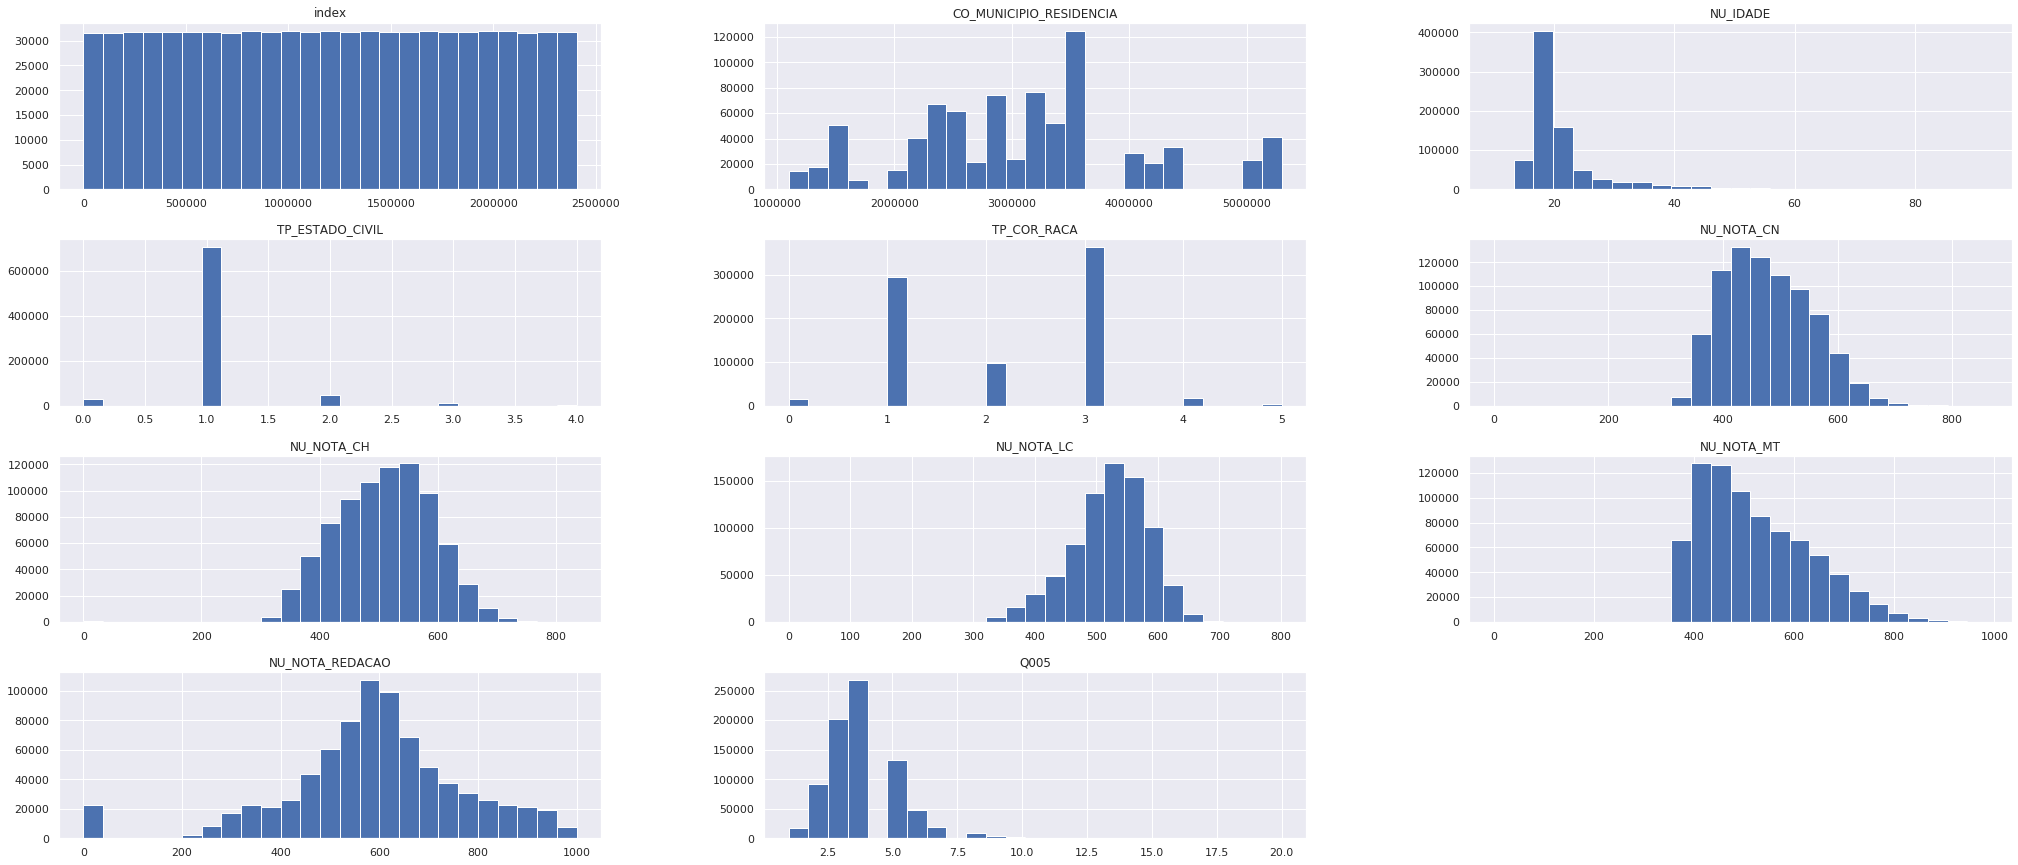

In [72]:
num_attributes.hist(bins=25);

### 1.7.2 Categorical Attributes

In [73]:
cat_attributes.dtypes

TP_SEXO    object
Q001       object
Q002       object
Q003       object
Q004       object
Q006       object
Q007       object
Q008       object
Q009       object
Q010       object
Q011       object
Q012       object
Q013       object
Q014       object
Q015       object
Q016       object
Q017       object
Q018       object
Q019       object
Q020       object
Q021       object
Q022       object
Q023       object
Q024       object
Q025       object
dtype: object

In [74]:
# Checking the unique values of each category
cat_attributes.apply(lambda x: x.unique())

TP_SEXO                                               [F, M]
Q001                                [D, B, E, A, H, F, C, G]
Q002                                [C, D, B, G, A, E, F, H]
Q003                                      [C, B, A, F, D, E]
Q004                                      [B, A, D, C, F, E]
Q006       [D, C, F, B, L, H, G, N, E, I, P, A, O, J, Q, ...
Q007                                            [A, B, D, C]
Q008                                         [B, C, D, E, A]
Q009                                         [D, C, B, E, A]
Q010                                         [B, C, A, D, E]
Q011                                         [A, B, C, D, E]
Q012                                         [B, D, C, A, E]
Q013                                         [A, C, B, D, E]
Q014                                         [A, B, C, D, E]
Q015                                         [A, B, C, D, E]
Q016                                         [A, B, C, E, D]
Q017                    

In [ ]:
sns.pairplot(df1)

# 2.0. Hypotesis

In [16]:
df2 = df1.copy()

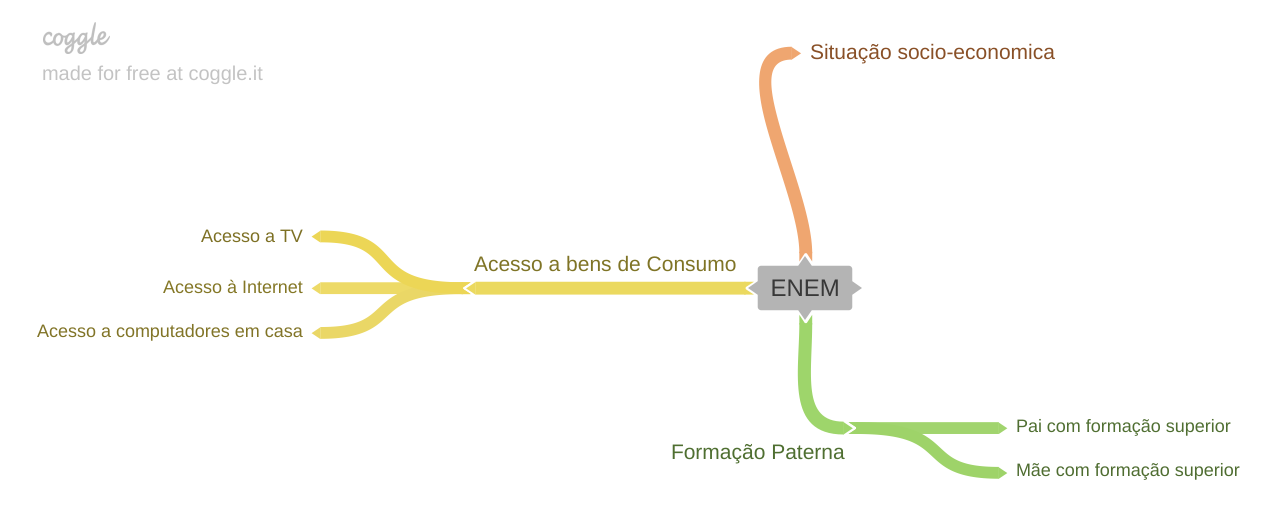

In [ ]:
Image('ENEM.png')

### H1. A condição socio-economica pouco interfere no resultados das notas!
## **Falso**: Quanto melhor a condição financeira familiar do estudante maiores serão suas notas!

In [60]:
aux1 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q006']].groupby('Q006').mean()
aux1

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q006,,,,,
A,502.651711,440.733823,467.928977,486.315929,468.833105
B,523.245155,445.261526,474.953666,493.836638,475.924256
C,551.218259,461.879501,494.960702,511.850518,496.561516
D,576.354257,477.450491,511.804463,525.491318,521.643363
E,590.567284,483.598967,518.276231,530.867117,529.975801
F,613.444602,497.543767,531.725367,540.788513,553.695607
G,627.687237,503.013448,537.237195,545.029601,560.857196
H,651.407749,517.702347,549.468954,553.945861,582.924426
I,664.528004,524.764798,556.242344,558.322345,594.276840


* A	Nenhuma renda.

* B	Até R$ 998,00.

* C	De R$ 998,01 até R$ 1.497,00.

* D	De R$ 1.497,01 até R$ 1.996,00.

* E	De R$ 1.996,01 até R$ 2.495,00.

* F	De R$ 2.495,01 até R$ 2.994,00.

* G	De R$ 2.994,01 até R$ 3.992,00.

* H	De R$ 3.992,01 até R$ 4.990,00.

* I	De R$ 4.990,01 até R$ 5.988,00.

* J	De R$ 5.988,01 até R$ 6.986,00.

* K	De R$ 6.986,01 até R$ 7.984,00.

* L	De R$ 7.984,01 até R$ 8.982,00.

* M	De R$ 8.982,01 até R$ 9.980,00.

* N	De R$ 9.980,01 até R$ 11.976,00.

* O	De R$ 11.976,01 até R$ 14.970,00.

* P	De R$ 14.970,01 até R$ 19.960,00.

* Q	Mais de R$ 19.960,00.

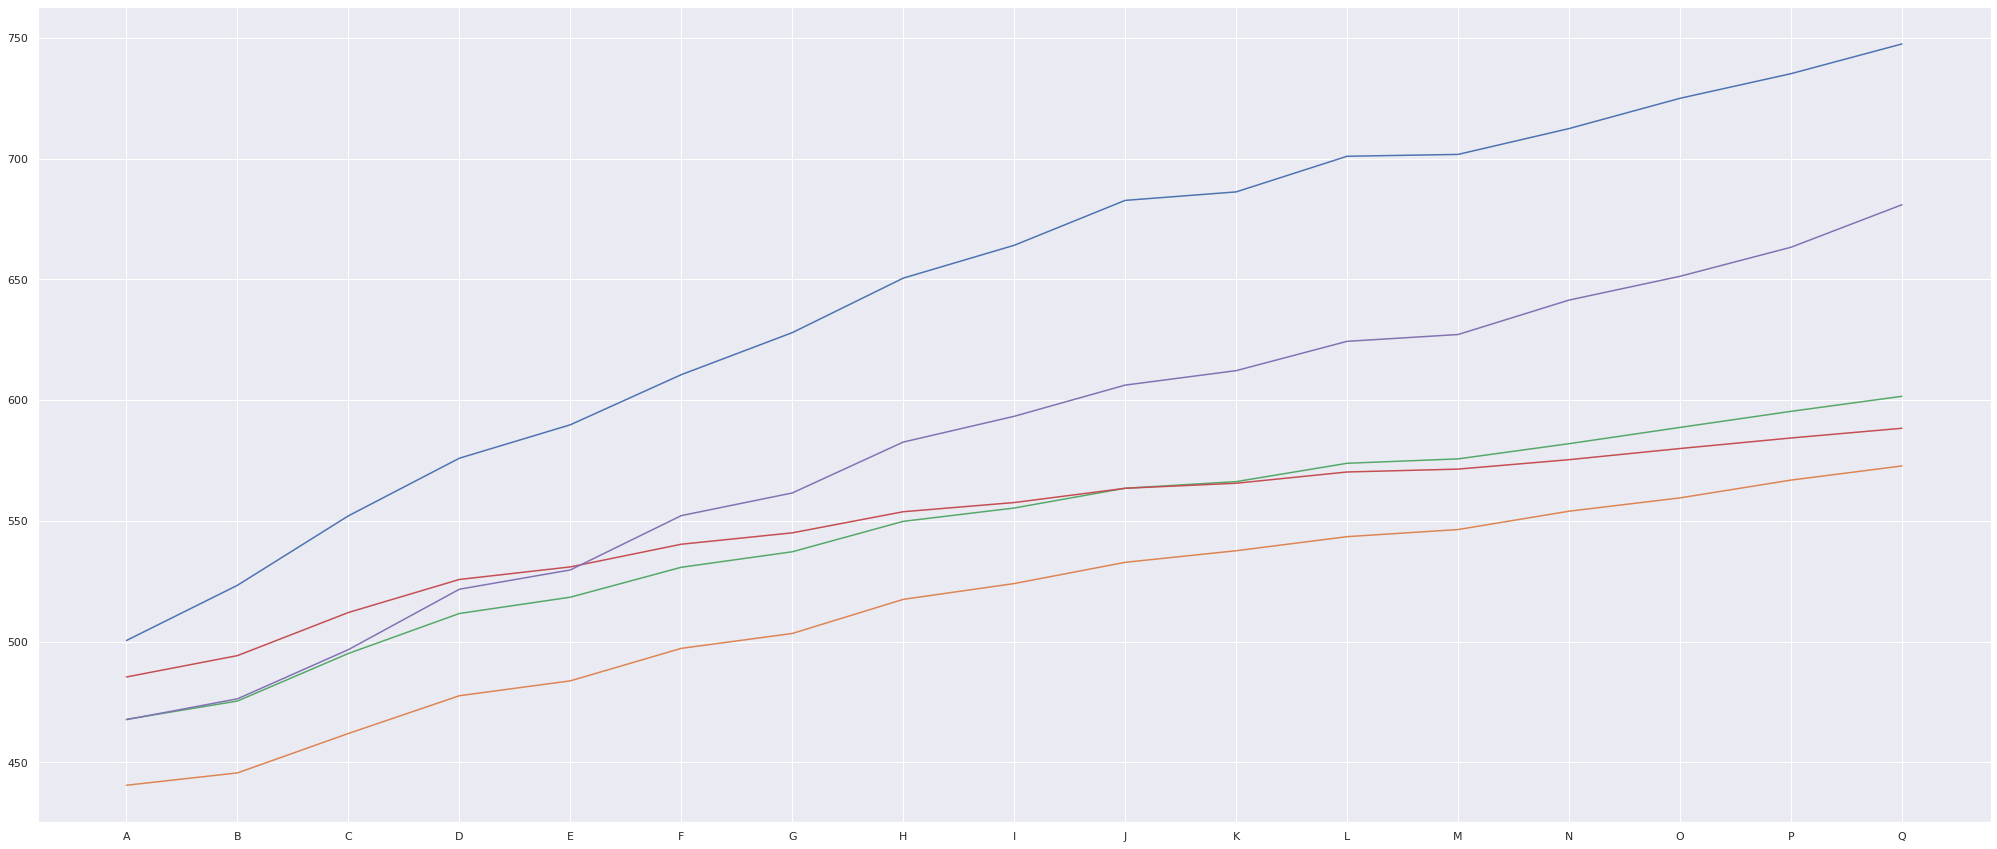

In [40]:
a = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q006']].groupby('Q006').mean()
plt.plot(a);

### H2. Alunos com acesso a TV em casa obtem melhores resultados?
## **Verdadeiro!**

In [ ]:
aux2 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q019']].groupby('Q019').mean()
aux2

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q019,,,,,
A,542.73953,461.78969,492.73894,506.74913,497.28139
B,558.84949,465.91893,497.66249,512.79437,504.34885
C,619.32269,500.14921,533.65628,541.80630,557.46838
D,658.16112,521.37825,553.34756,556.47273,592.34525
E,690.74429,539.47419,569.17217,567.91909,624.38834


* A	Não.

* B	Sim, uma.

* C	Sim, duas.

* D	Sim, três.

* E	Sim, quatro ou mais.

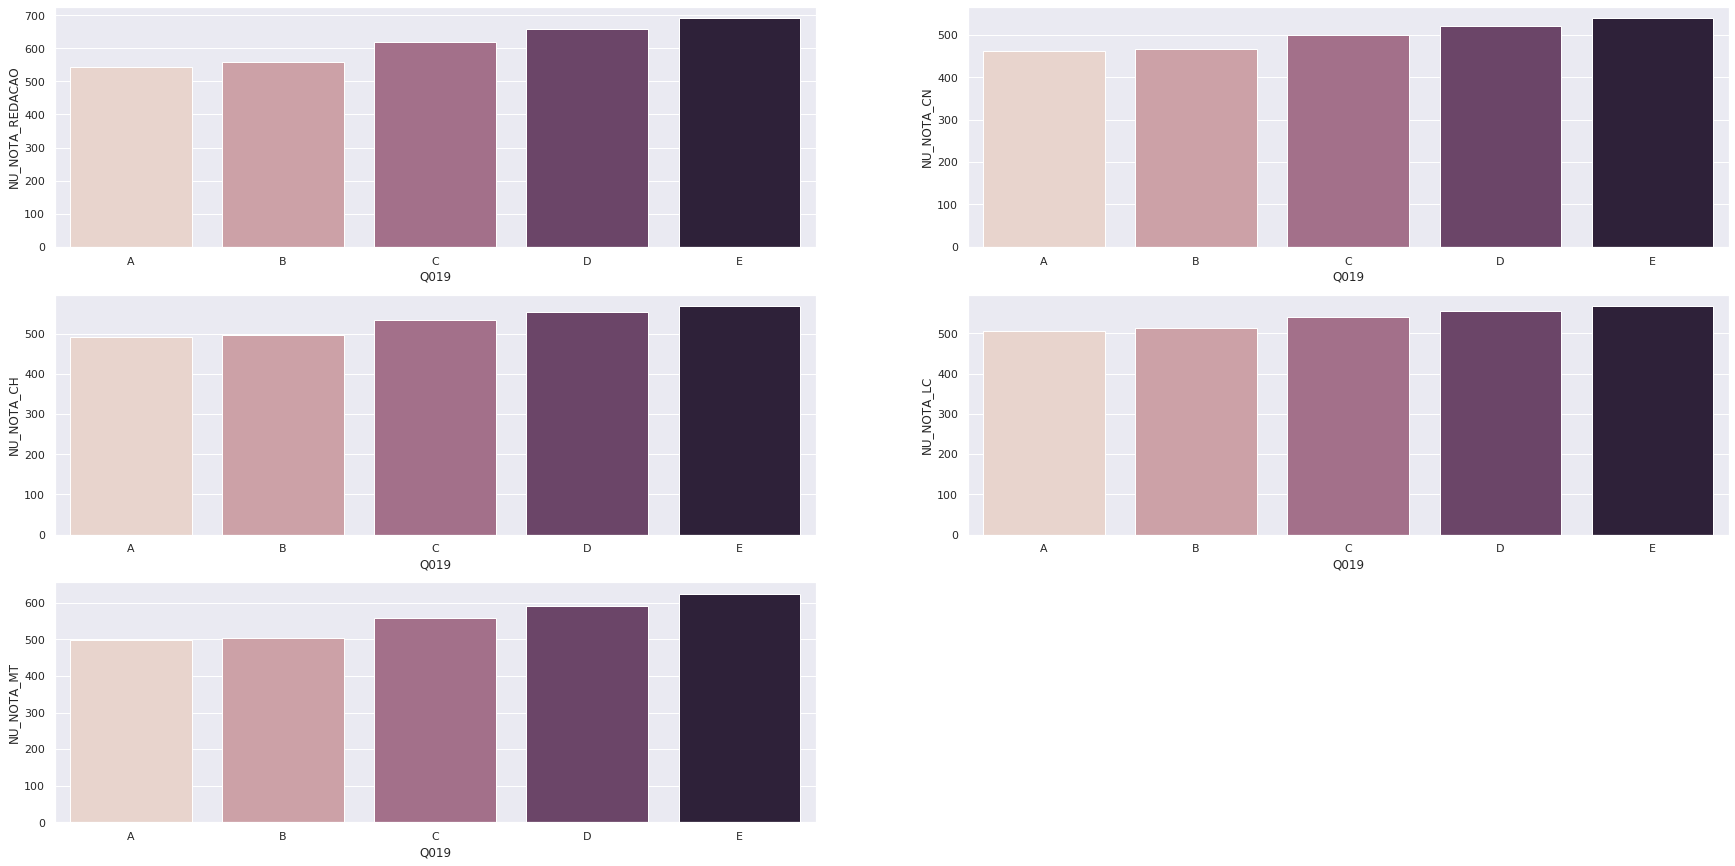

In [ ]:
#plt.plot(aux2);
plt.subplot(3, 2, 1)
# Checking product assortment size and sales by each store type. Let's look at which variables make sense to group and return this value
# showing the sum of sales per store categorized by display type (number of products)
aux1 = df2[['NU_NOTA_REDACAO', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_REDACAO', data=aux1, palette="ch:.05");

plt.subplot(3, 2, 2)
# O aux1 já responde essas questão. Daqui em diante vou validar se "extra", "basic" e "extend" 
#faz jús ao tamanho da loja e não apenas um breve comportamento dos clientes.
aux2 = df2[['NU_NOTA_CN', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_CN', data=aux2, palette="ch:.05");

plt.subplot(3, 2, 3)
aux3 = df2[['NU_NOTA_CH', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_CH', data=aux3, palette="ch:.05");

plt.subplot(3, 2, 4)
aux4 = df2[['NU_NOTA_LC', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_LC', data=aux4, palette="ch:.05");

plt.subplot(3, 2, 5)
aux5 = df2[['NU_NOTA_MT', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_MT', data=aux5, palette="ch:.05");

### H3. Alunos com acesso a internet em casa obtem melhores resultados?
## **Verdadeiro!**
* B = sim à acesso a internet
* A = Não á acesso a internet

In [ ]:
# Notas relacionadas ao acesso ou não a internet em casa
b = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q025']].groupby('Q025').mean()
b

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q025,,,,,
A,515.44872,445.43019,474.71460,492.26096,474.71820
B,596.94919,486.57529,519.29975,530.47258,536.15826


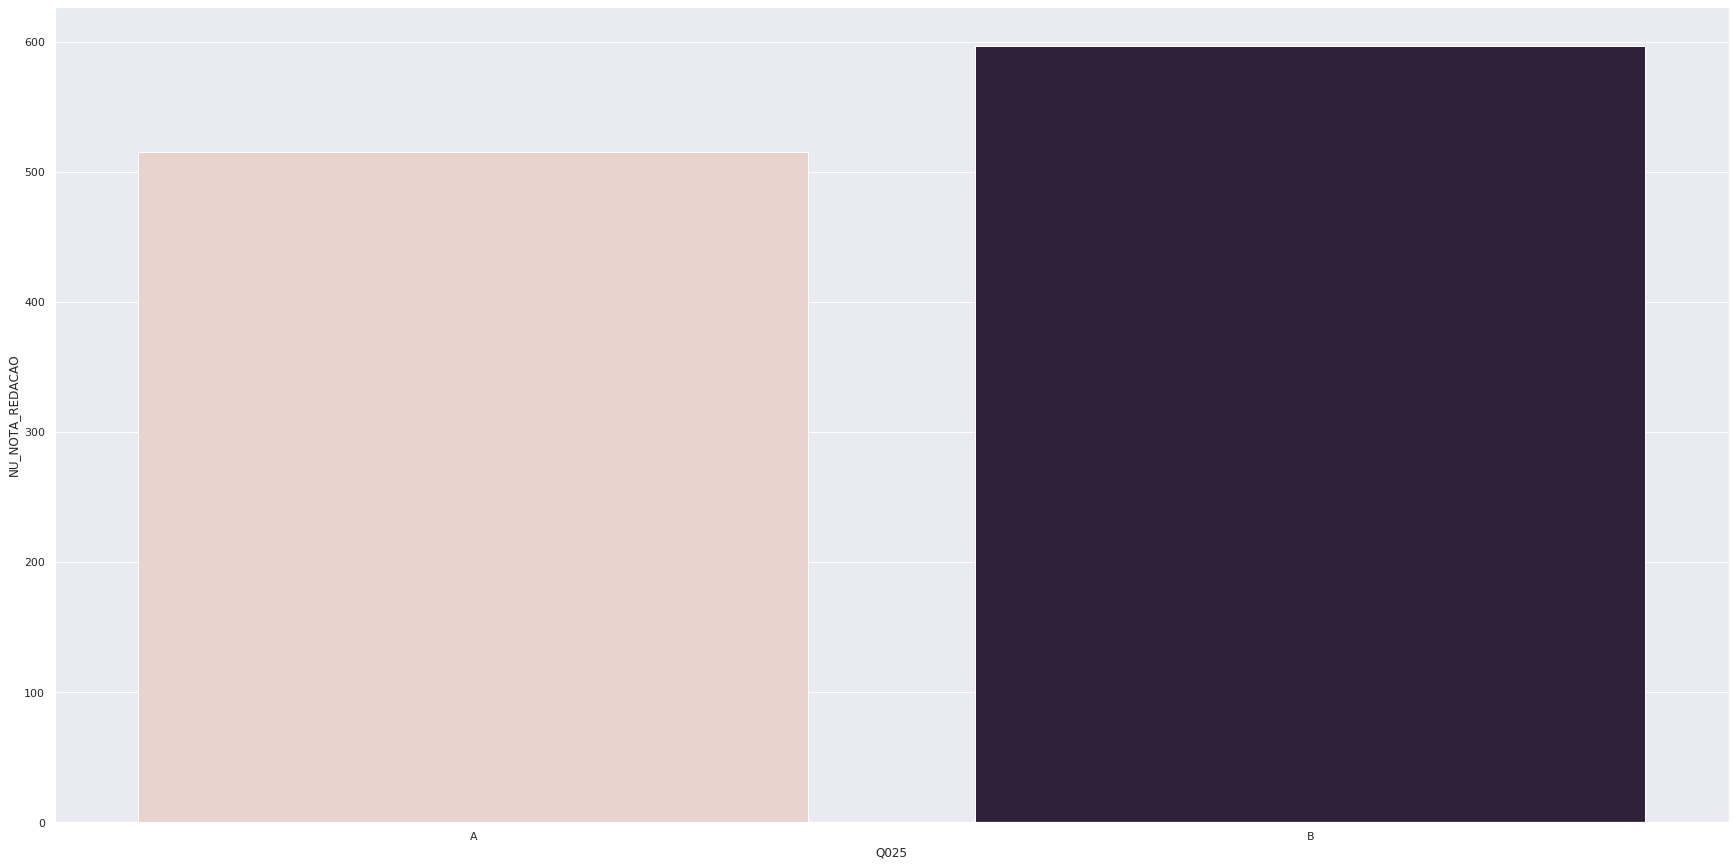

In [ ]:
#plt.subplot(3, 2, 1)
# Checking product assortment size and sales by each store type. Let's look at which variables make sense to group and return this value
# showing the sum of sales per store categorized by display type (number of products)
aux1 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q025']].groupby('Q025').mean().reset_index()
sns.barplot(x='Q025', y='NU_NOTA_REDACAO', data=aux1, palette="ch:.05");


### H4. Alunos com acesso a computadores em casa obtem melhores resultados?
## **Verdadeiro!**

* A Não.

* B Sim, um.

* C Sim, dois.

* D Sim, três.

* E Sim, quatro ou mais.

In [ ]:
# Notas relacionadas ao acesso ou não a internet em casa
aux3 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q024']].groupby('Q024').mean()
aux3

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q024,,,,,
A,529.77876,450.04375,480.65617,499.30938,483.37254
B,602.01657,489.16719,522.65246,533.07010,538.00111
C,669.82030,531.01457,563.27841,563.01622,601.88578
D,701.04299,551.37437,581.80692,576.07783,635.90393
E,715.85287,564.01981,592.94121,583.78828,661.02960


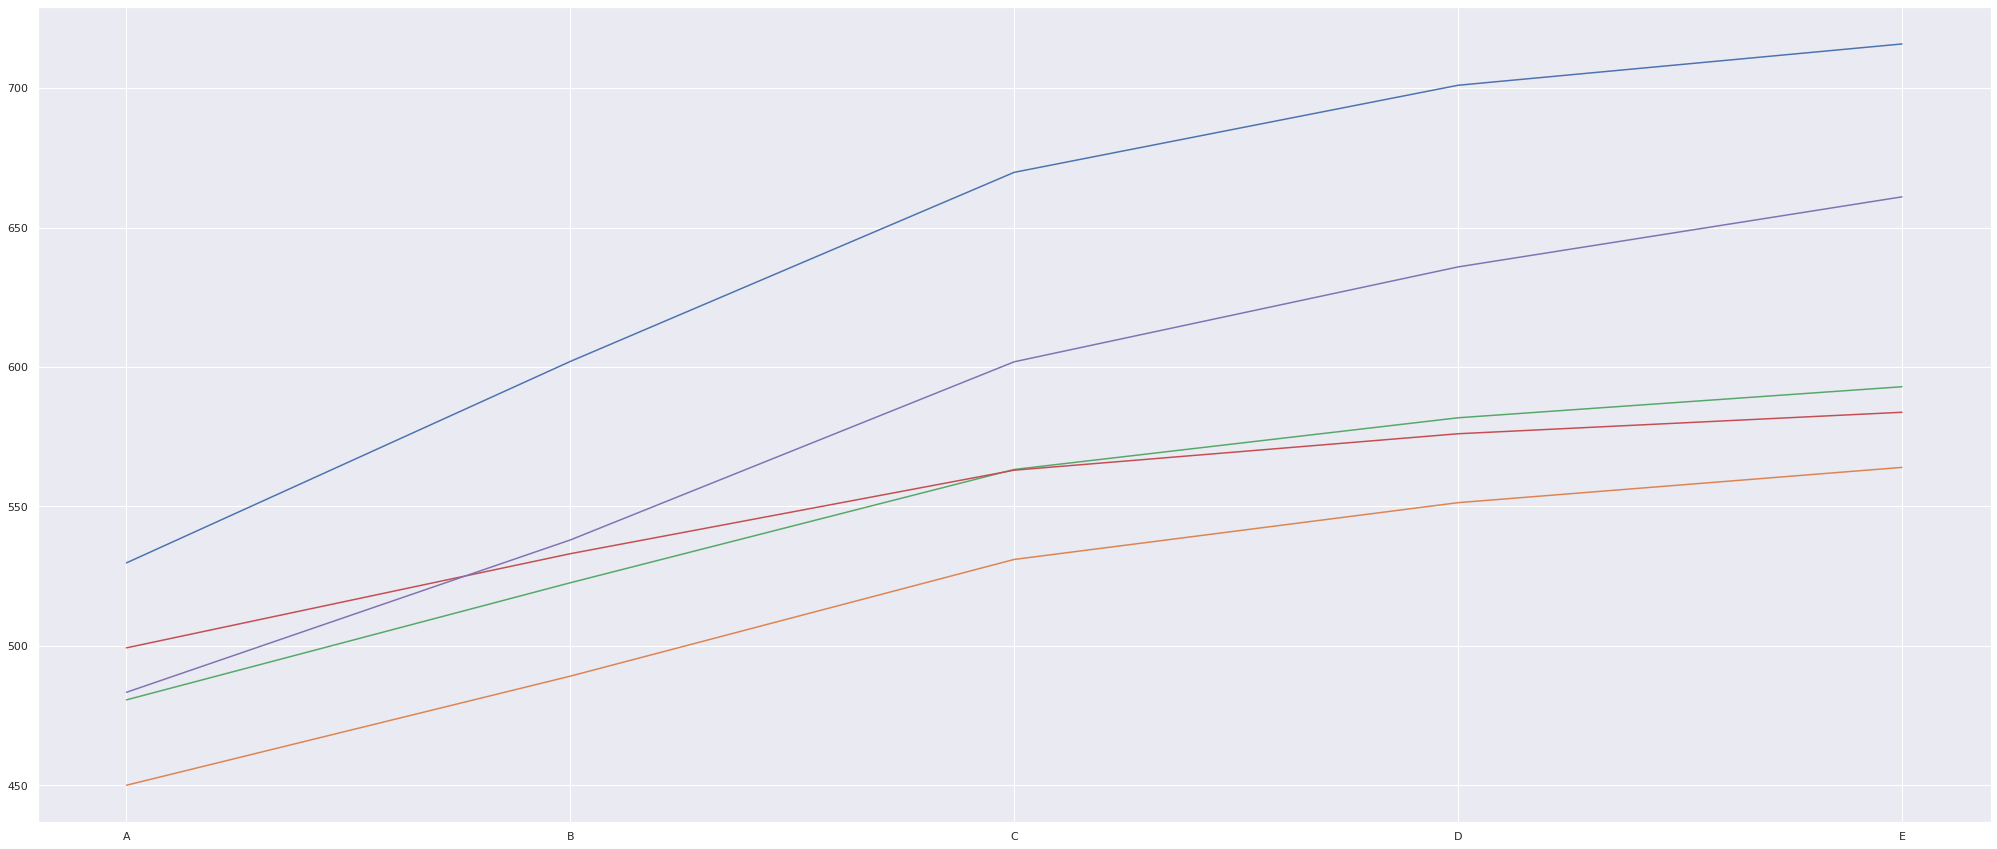

In [ ]:
plt.plot(aux3);

### H5. Alunos cujo os pais tem formação superior, tem as melhores notas!
## **Verdadeiro!**

* A	Nunca estudou.

* B	Não completou a 4ª série/5º ano do Ensino Fundamental.

* C	Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.

* D	Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.

* E	Completou o Ensino Médio, mas não completou a Faculdade.

* F	Completou a Faculdade, mas não completou a Pós-graduação.

* G	Completou a Pós-graduação.

* H	Não sei.


In [ ]:
# Notas relacionadas ao acesso ou não a internet em casa
aux4 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q001']].groupby('Q001').mean()
aux4

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q001,,,,,
A,495.76855,442.38214,471.99219,486.74540,466.23319
B,532.62101,454.43000,486.17798,502.14248,486.54550
C,558.09236,465.19686,497.68100,513.10752,505.23820
D,574.69698,471.90524,504.55876,519.72348,515.63902
E,604.85021,488.25642,521.22789,533.26858,538.98070
F,673.57643,528.81595,559.46286,560.84113,600.06957
G,700.19290,543.74764,572.61982,569.34630,624.23914
H,537.00840,459.96594,492.40487,509.21908,495.55026


### H6. Alunos cujo as mães tem formação superior, tem as melhores notas!
## **Verdadeiro!**

* A	Nunca estudou.

* B	Não completou a 4ª série/5º ano do Ensino Fundamental.

* C	Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.

* D	Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.

* E	Completou o Ensino Médio, mas não completou a Faculdade.

* F	Completou a Faculdade, mas não completou a Pós-graduação.

* G	Completou a Pós-graduação.

* H	Não sei.


In [ ]:
# Notas relacionadas ao acesso ou não a internet em casa
aux5 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q002']].groupby('Q002').mean()
aux5

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q002,,,,,
A,482.22510,440.87367,470.83069,484.04215,460.08365
B,522.30264,451.52821,483.69718,499.10212,480.26270
C,543.75971,459.67351,492.33407,508.19737,496.08270
D,559.02756,464.78703,497.60777,514.14613,504.91339
E,590.96451,480.82045,513.75431,527.58138,528.24786
F,655.50363,517.36626,547.90661,552.33342,583.39881
G,676.16517,527.05217,556.79970,558.13227,598.75662
H,504.78207,450.72796,479.11794,494.98531,484.34807


In [ ]:
df3.columns

Index(['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA',
       'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',
       'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
       'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
       'Q023', 'Q024', 'Q025'],
      dtype='object')

# 30. EDA

In [17]:
df3 = df2.copy()

### 3.1. Univariate Analysis

In [ ]:
num_attributes = df3

#### 3.1.0. Numerical Variable

In [62]:
num_attributes.hist(bins=25, color='brown');
plt.rcParams['figure.figsize'] = [30, 15]

NameError: ignored

#### 3.2.0. Categorical Varible

In [ ]:
cat_attributes.head()

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_SEXO,Q001,Q002,Q003,Q004,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,Ariquemes,RO,F,B,A,A,A,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,Belo Horizonte,MG,F,B,C,D,B,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,Manhuaçu,MG,M,E,B,C,D,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,Guarabira,PB,M,C,E,B,B,B,A,B,D,A,A,B,B,A,A,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,Fortaleza,CE,M,G,E,E,B,L,D,E,E,B,A,B,A,B,A,B,A,A,E,B,B,C,B,B,B


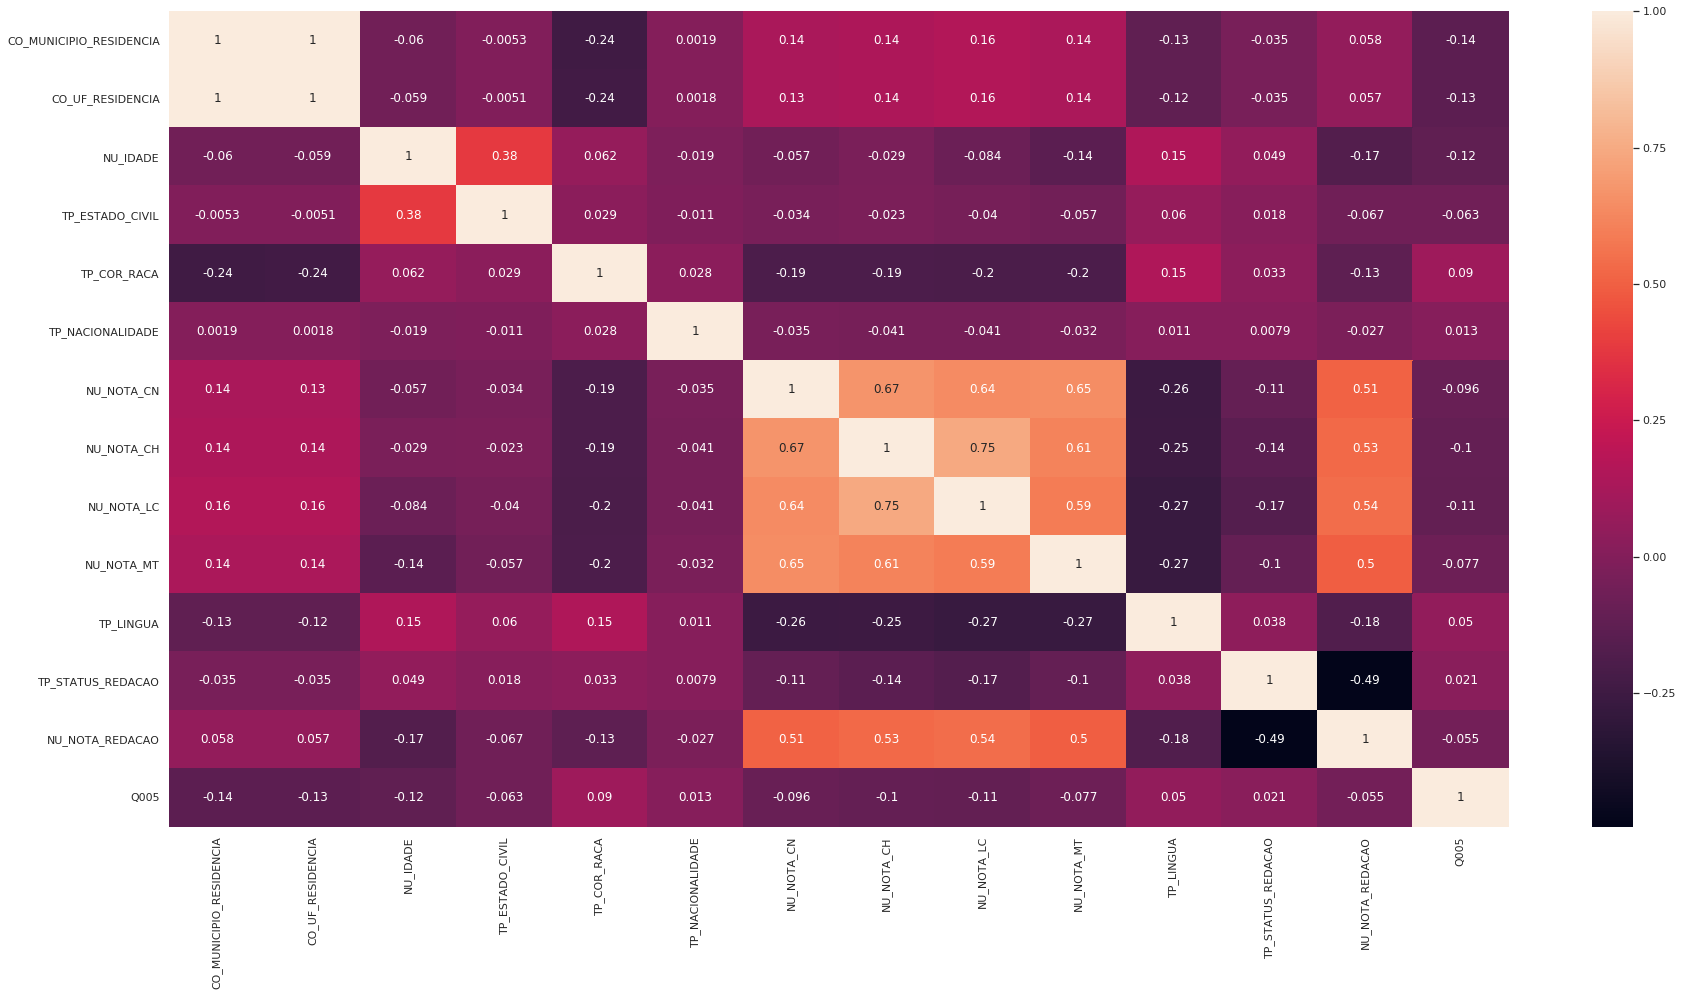

In [ ]:

sns.heatmap( df3.corr( method='pearson'), annot=True);

In [ ]:
tab = [['Hyposthesis', 'Conclusion', 'Relevance'],
       ['H1', 'Verdadeiro', 'Alto'],
       ['H2', 'Verdadeiro', 'Alto'],
       ['H3', 'Verdadeiro', 'Alto'],
       ['H4', 'Verdadeiro', 'Alto'],
       ['H5', 'Verdadeiro', 'Alto'],
       ['H6', 'Verdadeiro', 'Alto'],
      ]
print( tabulate( tab, headers='firstrow'))

Hyposthesis    Conclusion    Relevance
-------------  ------------  -----------
H1             Falso         Alto
H2             Verdadeiro    Alto
H3             Verdadeiro    Alto
H4             Verdadeiro    Alto
H5             Verdadeiro    Alto
H6             Verdadeiro    Alto


# 4.0 Data Preparation

In [61]:
df4 = df3.copy()

## 4.1 Reescaling

In [ ]:
num_attributes.hist(bins=25);

## 4.2 Encoding

In [56]:
#df4.head()

,index,CO_MUNICIPIO_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,2096578,3119401,17,F,1,2,444.60,456.20,476.60,469.10,600.00,D,C,C,B,4,D,A,B,D,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,B
1,1850813,3304557,36,F,1,2,645.90,658.90,632.20,781.60,720.00,D,D,B,B,3,D,A,C,C,C,A,B,C,B,A,A,A,B,D,B,B,D,B,C,B
2,718453,2931350,35,M,2,3,512.10,443.70,493.50,457.70,480.00,B,B,B,A,3,D,A,B,B,A,B,B,A,A,A,A,A,A,B,A,A,C,A,B,B
3,358467,2800308,16,F,1,3,408.80,479.40,469.30,561.20,0.00,E,G,B,D,5,C,A,B,D,A,A,B,A,A,A,B,A,A,B,A,B,C,A,B,B
4,9238,5208707,16,M,1,1,588.50,578.20,553.00,635.20,680.00,E,D,C,C,4,F,A,B,C,B,B,B,B,B,B,B,A,A,C,A,A,D,B,B,B


In [65]:
df4.head()

,index,CO_MUNICIPIO_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,2096578,3119401,17,0,1,2,444.60,456.20,476.60,469.10,600.00,4,3,2,1,4,0.10,0,0.68,0.32,0.36,0.77,0.94,0.62,0.40,0.88,0.49,0.97,0,0.67,0,0,0.30,0,0.44,1
1,1850813,3304557,36,0,1,2,645.90,658.90,632.20,781.60,720.00,4,4,1,1,3,0.10,0,0.22,0.50,0.08,0.77,0.94,0.02,0.59,0.88,0.49,0.97,1,0.06,1,1,0.29,1,0.08,1
2,718453,2931350,35,1,2,3,512.10,443.70,493.50,457.70,480.00,2,2,1,0,3,0.10,0,0.68,0.12,0.54,0.21,0.94,0.62,0.40,0.88,0.49,0.97,0,0.67,0,0,0.30,0,0.44,1
3,358467,2800308,16,0,1,3,408.80,479.40,469.30,561.20,0.00,5,7,1,3,5,0.24,0,0.68,0.32,0.54,0.77,0.94,0.62,0.40,0.88,0.50,0.97,0,0.67,0,1,0.30,0,0.44,1
4,9238,5208707,16,1,1,1,588.50,578.20,553.00,635.20,680.00,5,4,2,2,4,0.05,0,0.68,0.50,0.36,0.21,0.94,0.35,0.59,0.12,0.50,0.97,0,0.19,0,0,0.29,1,0.44,1


In [62]:
# Label Encoding
le = LabelEncoder()
df4['TP_SEXO'] = le.fit_transform(df4['TP_SEXO'])
df4['Q007'] = le.fit_transform(df4['Q007'])


In [63]:
# Ordinal Encoding
value_8 = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H':8}
df4['Q001'] = df4['Q001'].map(value_dict)
df4['Q002'] = df4['Q002'].map(value_dict)

value_6 = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}
df4['Q003'] = df4['Q003'].map(value_6)
df4['Q004'] = df4['Q004'].map(value_6)

value_2 = {'A': 0, 'B': 1}
df4['Q018'] = df4['Q018'].map(value_2)
df4['Q020'] = df4['Q020'].map(value_2)
df4['Q021'] = df4['Q021'].map(value_2)
df4['Q023'] = df4['Q023'].map(value_2)
df4['Q025'] = df4['Q025'].map(value_2)


In [64]:
# Frequency Encoder
df_Q6 = df4.groupby('Q006').size()/len(df4)
df4.loc[:, 'Q006'] = df4['Q006'].map(df_Q6)

df_Q8 = df4.groupby('Q008').size()/len(df4)
df4.loc[:, 'Q008'] = df4['Q008'].map(df_Q8)

df_Q9 = df4.groupby('Q009').size()/len(df4)
df4.loc[:, 'Q009'] = df4['Q009'].map(df_Q9)

df_Q10 = df4.groupby('Q010').size()/len(df4)
df4.loc[:, 'Q010'] = df4['Q010'].map(df_Q10)

df_Q11 = df4.groupby('Q011').size()/len(df4)
df4.loc[:, 'Q011'] = df4['Q011'].map(df_Q11)

df_Q12 = df4.groupby('Q012').size()/len(df4)
df4.loc[:, 'Q012'] = df4['Q012'].map(df_Q12)

df_Q13 = df4.groupby('Q013').size()/len(df4)
df4.loc[:, 'Q013'] = df4['Q013'].map(df_Q13)

df_Q14 = df4.groupby('Q014').size()/len(df4)
df4.loc[:, 'Q014'] = df4['Q014'].map(df_Q14)

df_Q15 = df4.groupby('Q015').size()/len(df4)
df4.loc[:, 'Q015'] = df4['Q015'].map(df_Q15)

df_Q16 = df4.groupby('Q016').size()/len(df4)
df4.loc[:, 'Q016'] = df4['Q016'].map(df_Q16)

df_Q17 = df4.groupby('Q017').size()/len(df4)
df4.loc[:, 'Q017'] = df4['Q017'].map(df_Q17)

df_Q19 = df4.groupby('Q019').size()/len(df4)
df4.loc[:, 'Q019'] = df4['Q019'].map(df_Q19)

df_Q22 = df4.groupby('Q022').size()/len(df4)
df4.loc[:, 'Q022'] = df4['Q022'].map(df_Q22)

df_Q24 = df4.groupby('Q024').size()/len(df4)
df4.loc[:, 'Q024'] = df4['Q024'].map(df_Q24)


In [66]:
df4.dtypes

index                        int64
CO_MUNICIPIO_RESIDENCIA      int64
NU_IDADE                     int64
TP_SEXO                      int64
TP_ESTADO_CIVIL              int64
TP_COR_RACA                  int64
NU_NOTA_CN                 float64
NU_NOTA_CH                 float64
NU_NOTA_LC                 float64
NU_NOTA_MT                 float64
NU_NOTA_REDACAO            float64
Q001                         int64
Q002                         int64
Q003                         int64
Q004                         int64
Q005                         int64
Q006                       float64
Q007                         int64
Q008                       float64
Q009                       float64
Q010                       float64
Q011                       float64
Q012                       float64
Q013                       float64
Q014                       float64
Q015                       float64
Q016                       float64
Q017                       float64
Q018                

## 4.2 Response Variable Tranformation

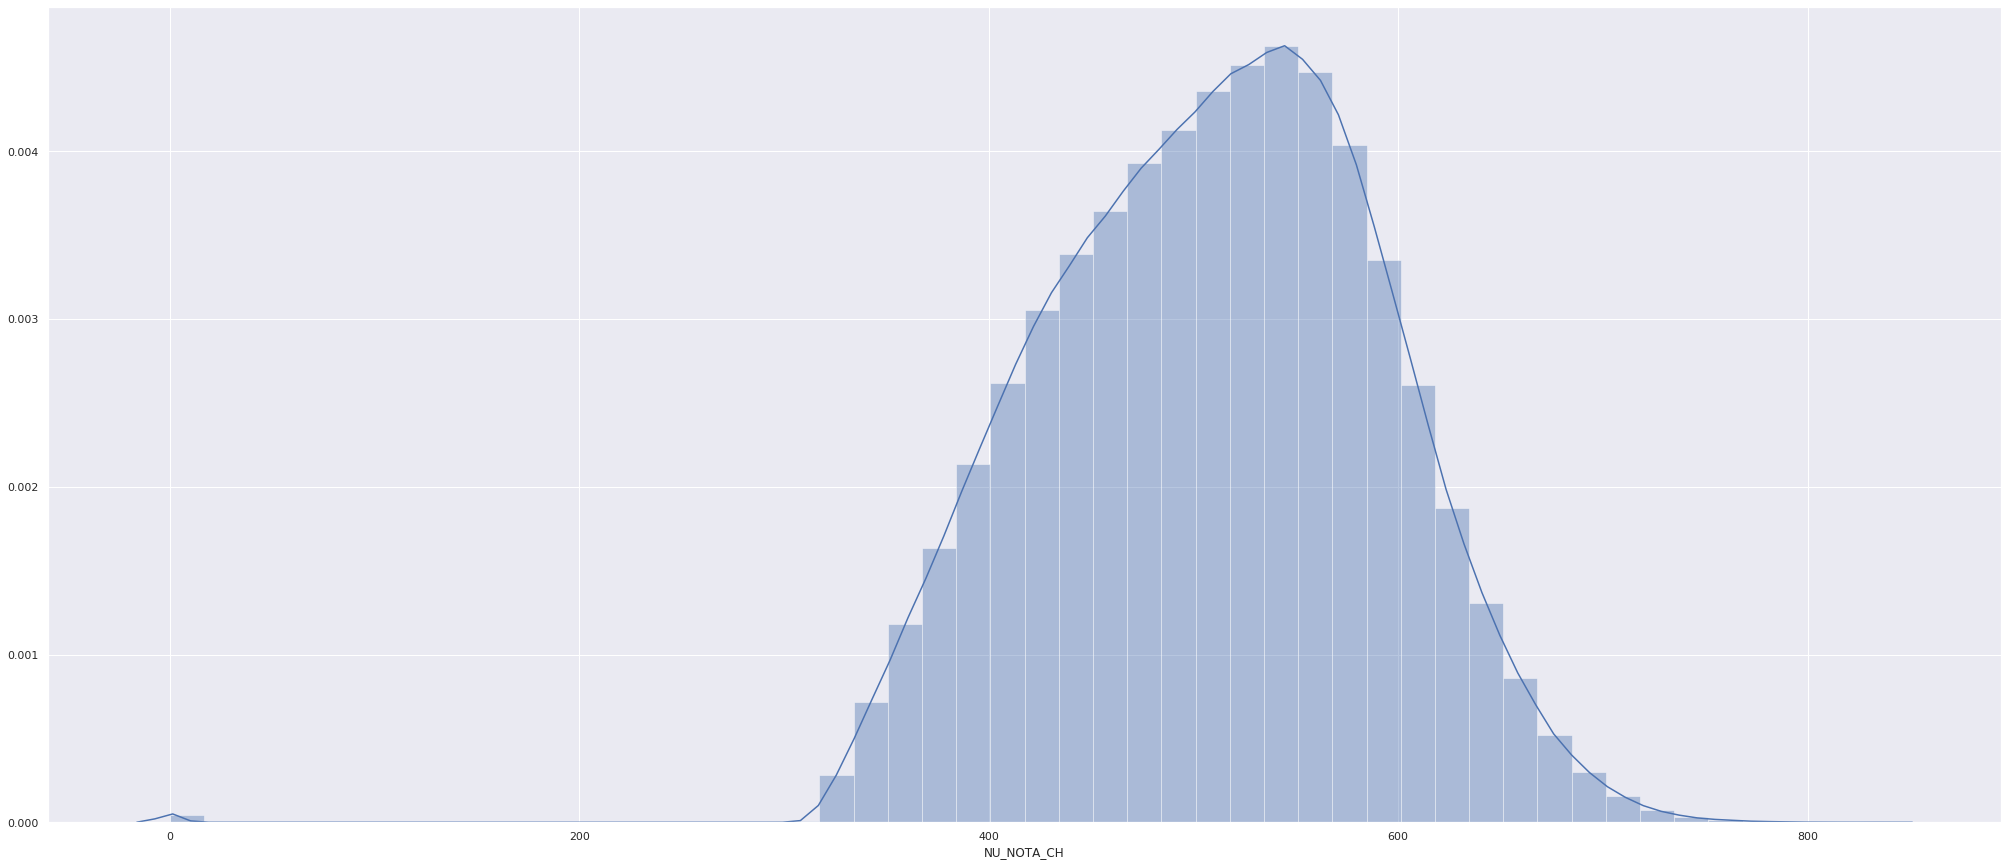

In [67]:
sns.distplot(df4['NU_NOTA_CH']);

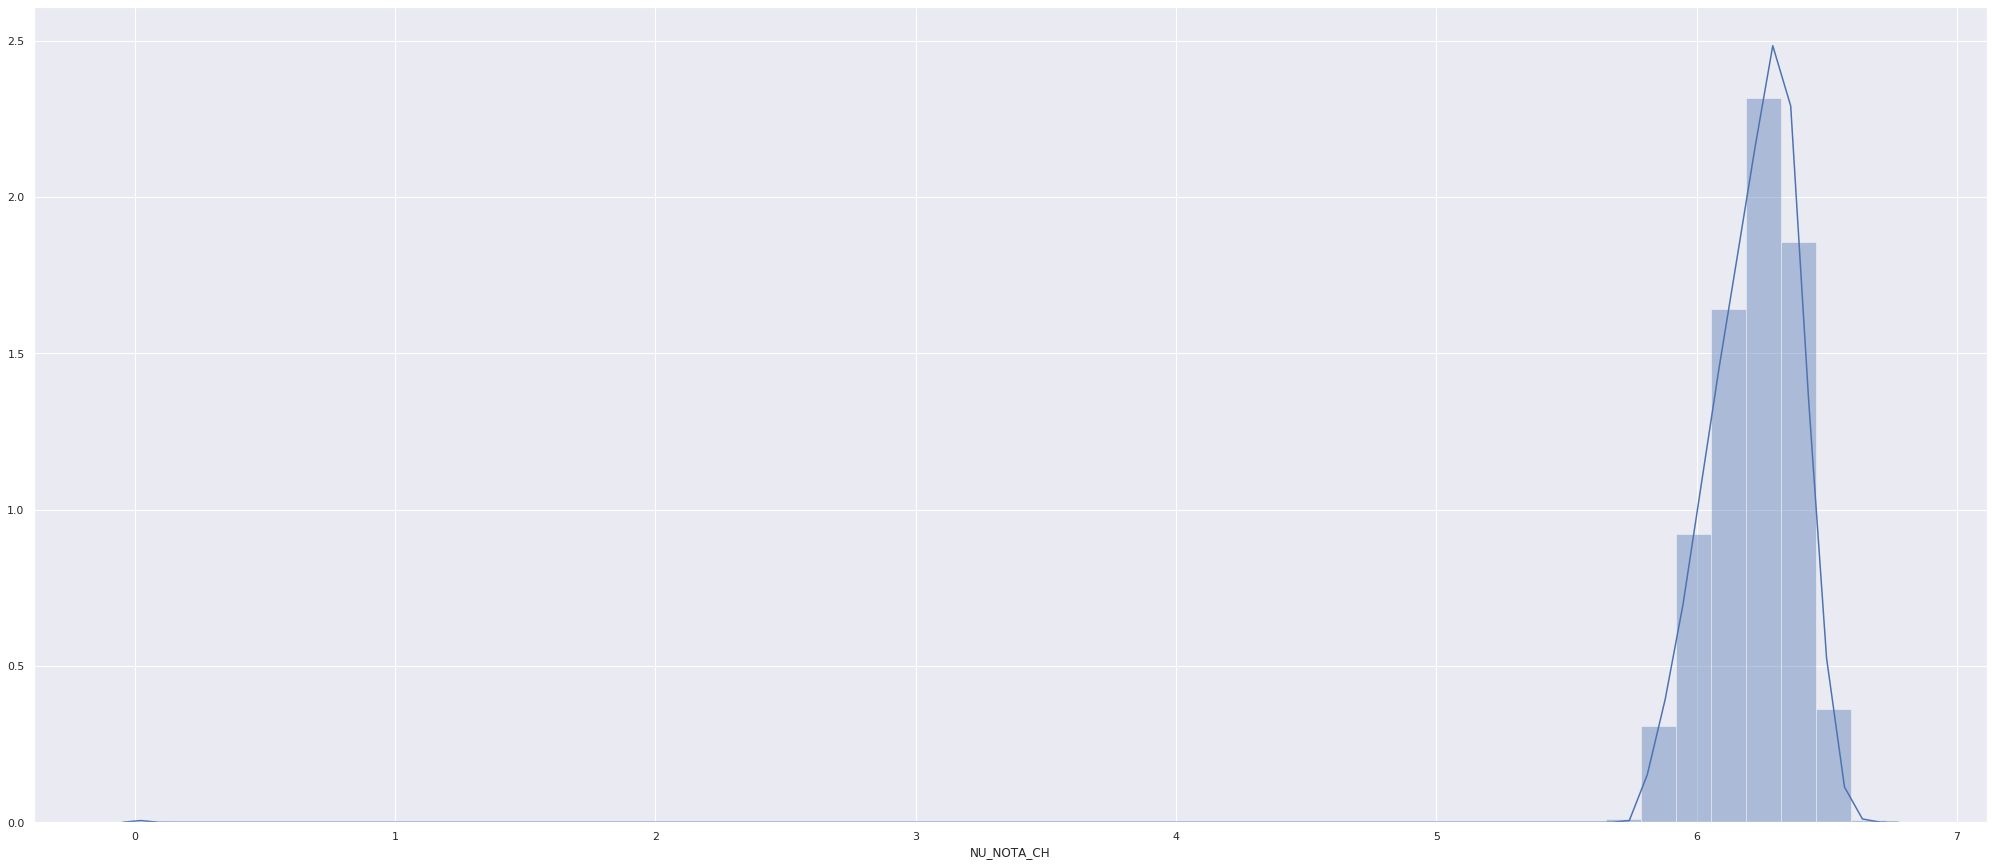

In [69]:
sns.distplot(df4['NU_NOTA_CH']);

In [68]:
df4['NU_NOTA_CH'] = np.log1p(df4['NU_NOTA_CH'])

# 4.0. CatBoost Regressor

In [27]:
#df4 = df2.copy()

In [54]:
df4.columns

Index(['index', 'CO_MUNICIPIO_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003',
       'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
       'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
       'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

In [35]:
X = df4.drop(df4[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']], axis=1)
y = df4[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']]

In [42]:
df4.dtypes

level_0                       int64
CO_MUNICIPIO_RESIDENCIA       int32
NU_IDADE                    float32
TP_SEXO                    category
TP_ESTADO_CIVIL                int8
TP_COR_RACA                    int8
NU_NOTA_CN                  float32
NU_NOTA_CH                  float32
NU_NOTA_LC                  float32
NU_NOTA_MT                  float32
NU_NOTA_REDACAO             float32
Q001                       category
Q002                       category
Q003                       category
Q004                       category
Q005                           int8
Q006                       category
Q007                       category
Q008                       category
Q009                       category
Q010                       category
Q011                       category
Q012                       category
Q013                       category
Q014                       category
Q015                       category
Q016                       category
Q017                       c

In [30]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.70, random_state=7)

In [31]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [32]:
# Aplicação do CatBoost
model = CatBoostRegressor(iterations=20,
                          depth=3,
                          learning_rate=0.1,
                          loss_function='RMSE')

# treino e teste
model.fit(X_train, y_train,
          cat_features=categorical_features_indices,
          eval_set=(X_validation, y_validation), plot=True)

CatBoostError: ignored